In [16]:
from fastai import *
from fastai.vision import *
import torch.onnx
from torch.autograd import Variable
from fastai.callbacks import *

import netron

In [2]:
import os

os.environ["TORCH_HOME"] = "/media/subhaditya/DATA/COSMO/Datasets-Useful"

In [3]:
path = untar_data(URLs.CIFAR_100)

In [4]:
data = (
    (
        ImageList.from_folder(path)
        .split_by_rand_pct()
        .label_from_folder()
        .transform(get_transforms(), size=128)
    )
    .databunch(bs=64)
    .normalize(imagenet_stats)
)

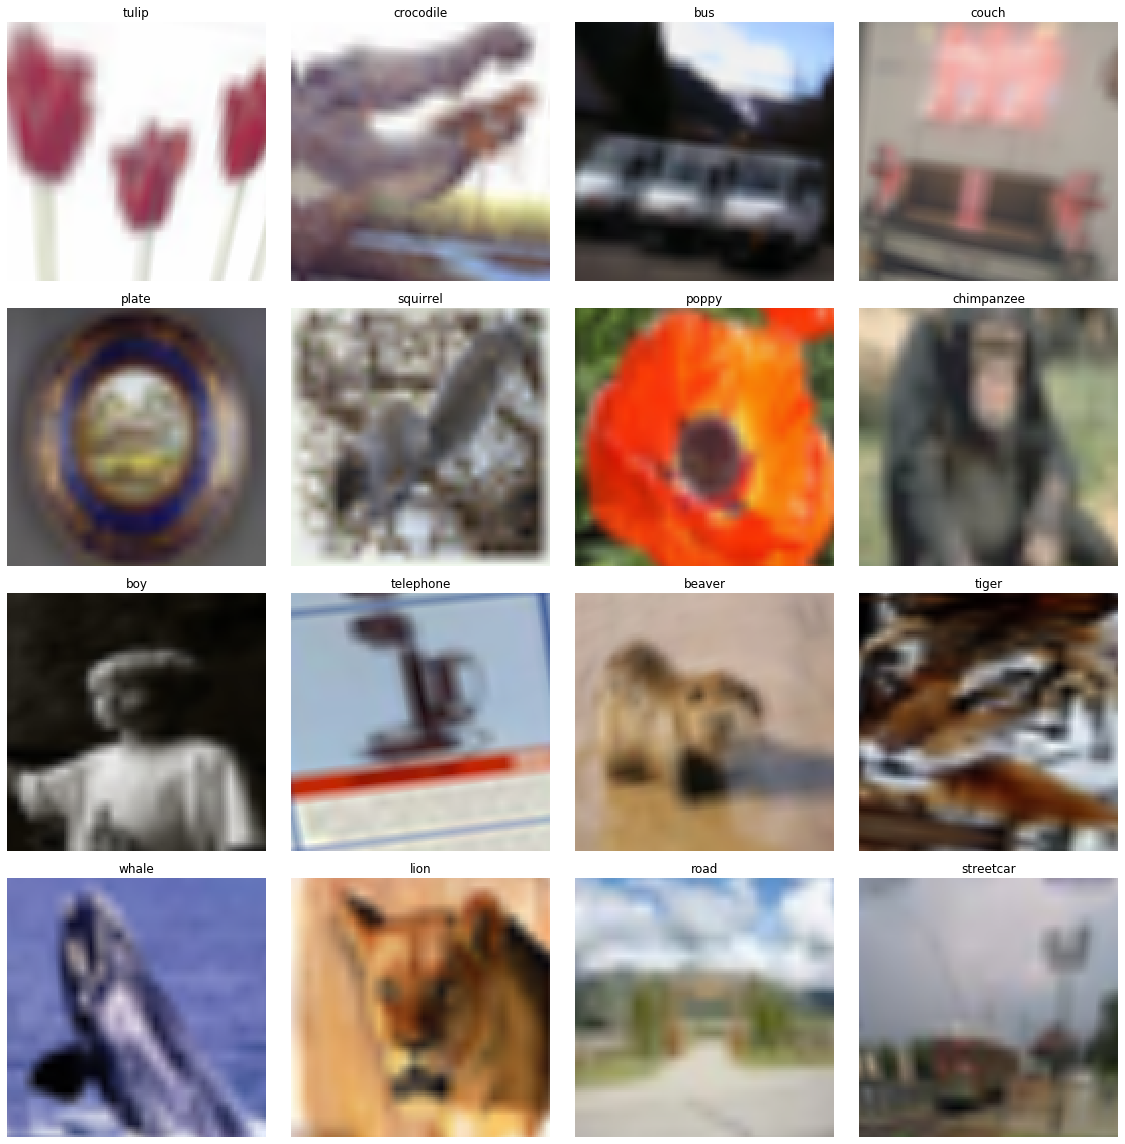

In [5]:
data.show_batch(4)

In [6]:
data.c

100

In [7]:
data

ImageDataBunch;

Train: LabelList (48000 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
cloud,cloud,cloud,cloud,cloud
Path: /home/subhaditya/.fastai/data/cifar100;

Valid: LabelList (12000 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
butterfly,skyscraper,keyboard,shark,whale
Path: /home/subhaditya/.fastai/data/cifar100;

Test: None

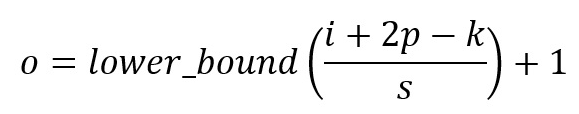

In [8]:
np.floor(((224)+2*2-11)/4)+1

55.0

In [9]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.part1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2),
        )
        self.part2 = nn.AdaptiveAvgPool2d((6, 6))
        self.part3 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 100),
        )

    def forward(self, x):
        x = self.part1(x)
        x = self.part2(x)
        x = torch.flatten(x, 1)
        x = self.part3(x)

        return x

In [17]:
learn = None
gc.collect()

479

In [18]:
learn = Learner(
    data, Model(), metrics=[accuracy,error_rate], callback_fns=[ShowGraph,ActivationStats]
).to_fp16()

In [19]:
learn.summary()

Model
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 31, 31]         23,296     True      
______________________________________________________________________
ReLU                 [64, 31, 31]         0          False     
______________________________________________________________________
MaxPool2d            [64, 15, 15]         0          False     
______________________________________________________________________
Conv2d               [192, 15, 15]        307,392    True      
______________________________________________________________________
ReLU                 [192, 15, 15]        0          False     
______________________________________________________________________
MaxPool2d            [192, 7, 7]          0          False     
______________________________________________________________________
Conv2d               [384, 7, 7]          663,936    True      
________________________________________________________

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,nan,nan,0.007917,0.992083,03:29


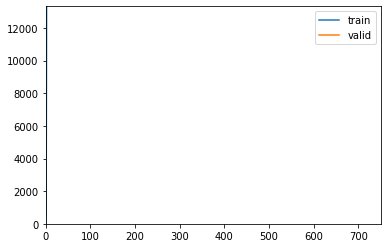

In [20]:
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


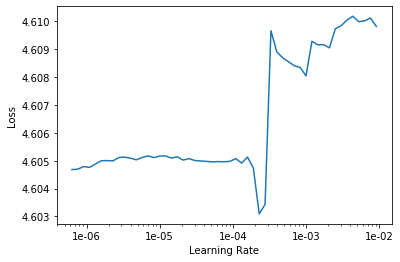

In [13]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.955102,3.941494,0.093167,0.906833,01:40
1,3.453122,3.322916,0.194667,0.805333,00:30
2,2.982974,2.929195,0.266833,0.733167,00:30
3,2.607836,2.612515,0.328750,0.671250,00:30
4,2.502686,2.537787,0.347833,0.652167,00:31


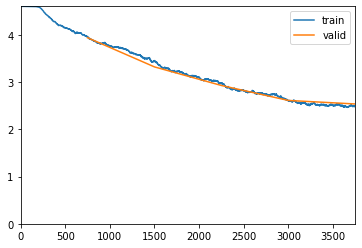

In [14]:
learn.fit_one_cycle(5, 1e-4)

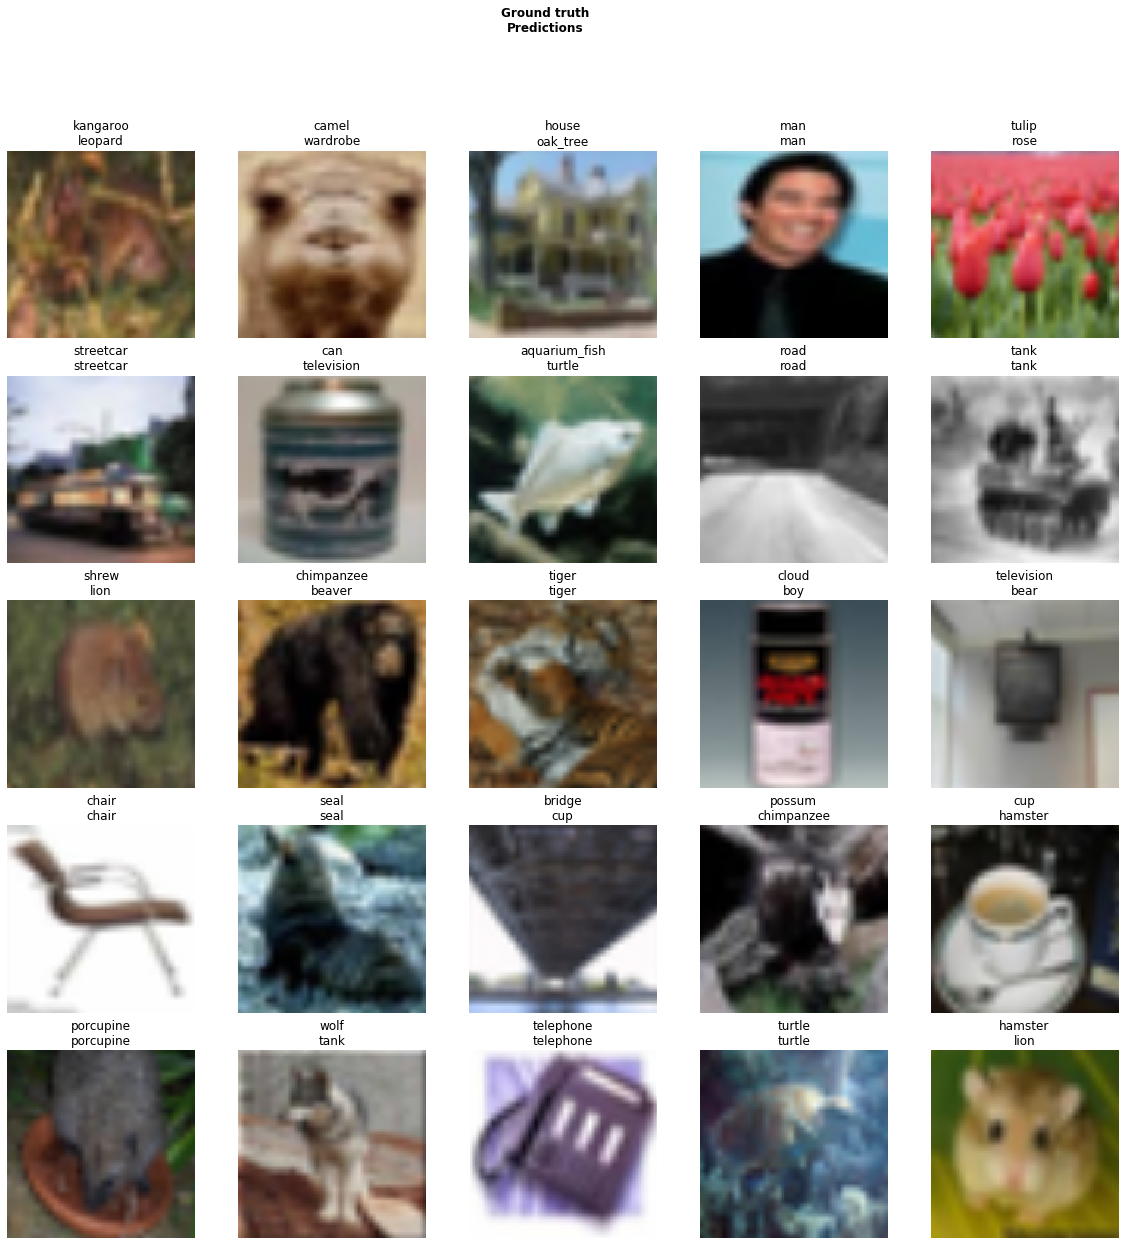

In [79]:
learn.show_results()

In [59]:
dummy_input = Variable(torch.randn(1, 3, 224, 224)).cuda().half()
torch.onnx.export(learn.model, dummy_input, "model.onnx")

In [60]:
netron.start("model.onnx")

Serving 'model.onnx' at http://localhost:8080


In [61]:
!rm "model.onnx"